<br><br><br>
<h2><font size=6>Práctica 1</font></h2>



<h1><font size=7>Árboles de decisión</font></h1>

<br>
<div style="text-align: right">
<font size=4>Pablo Torrijos Arenas (Pablo.Torrijos@uclm.es)</font><br>
<font size=4>José Miguel Puerta Callejón (Jose.Puerta@uclm.es)</font><br>
</div>

**<font color="#B30033" size=5>Estudiantes: </font>** 

* Estudiante 1
* (Estudiante 2)

---

# 1. Introducción

El objetivo de esta práctica es estudiar el uso de árboles de decisión para la predicción del ingreso de distintas personas en función de sus datos censales. Para ello usaremos la base de datos [`adult`](https://archive.ics.uci.edu/dataset/2/adult), también conocida como [`census-income`](https://archive.ics.uci.edu/dataset/20/census+income). 

En esta práctica comenzaremos explorando `scikit-learn` y su implementación de los árboles de decisión, realizando un estudio comparativo de los distintos hiperparámetros que ofrece. 

Posteriormente, se proporciona el esqueleto para la implementación del algoritmo C4.5 que usaremos como base para el resto de la práctica. A partir de ella, se pide:
- Capacidad de tratar con variables y discretas continuas.
- Implementar el error de clasificación, el índice GINI y la entropía condicional para el cálculo del error.
- Poda del árbol.
- Estudio del algoritmo implementado.

Baremo de puntuaciones:

| Tarea                     | Peso | 
|----------|----------|
| Estudio comparativo con `scikit-learn`      | 10%   |
| Variables discretas       | 15%   |
| Variables continuas       | 25%   |
| Implementación de las métricas           | 10%   |
| Poda del árbol            | 25%   |
| Estudio final del algoritmo implementado           | 15%   |



---

# 2. Carga del dataset

El dataset que usaremos trata de predecir si los ingresos son superiores o inferiores a 50K en base a una serie de variables. Para cargar los datos usaremos `pandas`, mientras que `numpy` será necesario para realizar diversas funciones a lo largo de la práctica.

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('adult.csv')
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


## 2.1. Análisis exploratorio

Podemos ver información de las distintas variables con `df.info()`:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


Así, vemos como efectivamente tenemos tanto variables categóricas como numéricas. En principio parece estar todo correcto, sin valores perdidos, pero si observamos los valores únicos de cada variable:

In [6]:
df.nunique()

age                  73
workclass             9
fnlwgt            21648
education            16
education-num        16
marital-status        7
occupation           15
relationship          6
race                  5
sex                   2
capital-gain        119
capital-loss         92
hours-per-week       94
native-country       42
income                2
dtype: int64

In [4]:
df.apply(lambda col: col.sort_values().unique())

age               [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 2...
workclass         [?, Federal-gov, Local-gov, Never-worked, Priv...
fnlwgt            [12285, 13769, 14878, 18827, 19214, 19302, 193...
education         [10th, 11th, 12th, 1st-4th, 5th-6th, 7th-8th, ...
education-num     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
marital-status    [Divorced, Married-AF-spouse, Married-civ-spou...
occupation        [?, Adm-clerical, Armed-Forces, Craft-repair, ...
relationship      [Husband, Not-in-family, Other-relative, Own-c...
race              [Amer-Indian-Eskimo, Asian-Pac-Islander, Black...
sex                                                  [Female, Male]
capital-gain      [0, 114, 401, 594, 914, 991, 1055, 1086, 1111,...
capital-loss      [0, 155, 213, 323, 419, 625, 653, 810, 880, 97...
hours-per-week    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
native-country    [?, Cambodia, Canada, China, Columbia, Cuba, D...
income                                          

Podemos ver cómo en `workclass`, `occupation` y `native-country` hay valores desconocidos representados por `?`. Vamos a ver cómo quedaría nuestro DataFrame si los reemplazamos por `NaN` para que `pandas` los reconozca como valores perdidos:

In [4]:
df.replace('?', np.nan).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


Así, ahora podemos ver cómo la cuenta de valores no nulos ha cambiado. Por defecto, como las variables eran categóricas, estaba contando las `?` como una categoría más. 

Cuando conocemos la causa de los valores perdidos puede tener sentido dejarlos como una categoría más. Por ejemplo, suponed que estamos recogiendo datos de un radar en el que la velocidad máxima que puede medir son 200 km/h. Si un coche pasa a 215 km/h el radar nos daría un `?` en ese dato, pero si sabemos el motivo de estos valores perdidos, podríamos cambiar el nombre de esa categoría a `>200km/h`.

Ya que en esta práctica no vamos a introducir el manejo de los valores perdidos en nuestros árboles de decisión, y puesto que dichos valores solo aparecen en variables categóricas, por simplicidad vamos a dejar la base de datos tal cual está, contando a `?` como un valor categórico más. 

## 2.2. De `pandas` a `numpy`

A continuación vamos a transformar nuestros datos en arrays de `numpy` ya que los necesitaremos para trabajar con ellos posteriormente. `pandas` tiene muchas características muy útiles para hacer el análisis exploratorio y el preprocesamiento de los datos gracias a sus funciones de selección, agregación, agrupación... pero posteriormente todos los algoritmos de aprendizaje automático suelen trabajar con arrays de `numpy` dada su velocidad.

Vamos a empezar con los nombres de las variables. Por un lado vamos a guardar cuáles son nuestras variables predictoras y cuál nuestra variable objetivo.

In [9]:
features = df.columns
features

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

In [10]:
attributes = features[:-1]
target = features[-1]

print('Predictoras:',attributes)
print('Objetivo:',target)

Predictoras: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Objetivo: income


Además, vamos a distinguir entre variables continuas (las que son de tipo `int64`) y discretas (de tipo `object`), ya que a la hora de hacer nuestros árboles de decisión habrá que tratarlas de forma distinta.

In [11]:
cont_atts = df.columns[df.dtypes == 'int64']

disc_atts = df.columns[df.dtypes == 'object'] 
disc_atts = disc_atts.drop(target)

print('Continuas:',cont_atts)
print('Discretas:',disc_atts)

Continuas: Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')
Discretas: Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object')


Finalmente, separamos el dataset en predictor y objetivo. Es convención en ciencia de datos usar $X$ para las variables predictoras e $y$ para la variable objetivo. La mayoría de los modelos se entrenan usando esas dos variables por separado.

In [12]:
X, y = df[attributes].to_numpy(), df[target].to_numpy()
X

array([[39, 'State-gov', 77516, ..., 0, 40, 'United-States'],
       [50, 'Self-emp-not-inc', 83311, ..., 0, 13, 'United-States'],
       [38, 'Private', 215646, ..., 0, 40, 'United-States'],
       ...,
       [58, 'Private', 151910, ..., 0, 40, 'United-States'],
       [22, 'Private', 201490, ..., 0, 20, 'United-States'],
       [52, 'Self-emp-inc', 287927, ..., 0, 40, 'United-States']],
      dtype=object)

In [13]:
y

array(['<=50K', '<=50K', '<=50K', ..., '<=50K', '<=50K', '>50K'],
      dtype=object)

## 2.3. Datos de test

Cuando nos enfrentamos a un problema de aprendizaje automático, es imprescindible que los datos de test que usemos para medir el rendimiento del modelo sean distintos a los datos con los que se entrena. En este caso, como los autores del conjunto de datos nos proporcionan un conjunto de datos separado para test, lo usaremos directamente. Si no, tendríamos que dividir el conjunto de datos original en dos partes, una para entrenar y otra para test.

**Nota:** En la práctica, es común dividir el conjunto de datos en tres partes: entrenamiento, validación y test. La validación se usa para ajustar los hiperparámetros del modelo, y el conjunto de test se usa para medir el rendimiento final del modelo. En este caso, como no vamos a ajustar hiperparámetros y por simplicidad, no usaremos conjunto de validación.

In [14]:
df_test = pd.read_csv('adult_test.csv')
df_test

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K
16277,64,?,321403,HS-grad,9,Widowed,?,Other-relative,Black,Male,0,0,40,United-States,<=50K
16278,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K
16279,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K


In [15]:
X_test, y_test = df_test[attributes].to_numpy(), df_test[target].to_numpy()
X_test

array([[25, 'Private', 226802, ..., 0, 40, 'United-States'],
       [38, 'Private', 89814, ..., 0, 50, 'United-States'],
       [28, 'Local-gov', 336951, ..., 0, 40, 'United-States'],
       ...,
       [38, 'Private', 374983, ..., 0, 50, 'United-States'],
       [44, 'Private', 83891, ..., 0, 40, 'United-States'],
       [35, 'Self-emp-inc', 182148, ..., 0, 60, 'United-States']],
      dtype=object)

In [16]:
y_test

array(['<=50K', '<=50K', '>50K', ..., '<=50K', '<=50K', '>50K'],
      dtype=object)

---

# 3. Árboles de decisión en `scikit-learn`



Para esta práctica vamos a utilizar el módulo [tree](http://scikit-learn.org/stable/modules/tree.html) de `scikit-learn`. Esta librería permite utilizar diversos algoritmos de _machine learning_ en Python, siendo los árboles de decisión uno de ellos. En particular, utilizaremos [`DecisionTreeClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), la implementación de un árbol de decisión para problemas de clasificación de `scikit-learn`. 

La implementación que tiene `scikit-learn` de los árboles de decisión no es exactamente la del C4.5 si no que el algoritmo se llama CART. Existen algunas diferencias, pero la que más nos afectará es que los árboles generados son **binarios** y que no puede tratar variables discretas sin un procesado previo. 

Por tanto, para poder usar este algoritmo con nuestros datos tendremos que convertir las variables categóricas a numéricas. Para ello, podríamos usar el método [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) de `scikit-learn`, pero usaremos el método `df.get_dummies()` que nos proporciona directamente `pandas` ya que es similar y más simple de aplicar. Este método básicamente crea una nueva columna por cada valor posible de cada variable categórica y pone un 1 en la columna correspondiente al valor de la fila y un 0 en las demás, pasando así de variables categóricas a numéricas:

![OneHotEnconding](./imagenes/get_dummies.png)

## 3.1. Transformación de los datos para usarlos con `DecisionTreeClassifier`

Vamos a transformar nuestros datos:

In [20]:
df_ohe = pd.get_dummies(df.drop(target, axis=1))
df_ohe

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,39,77516,13,2174,0,40,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,50,83311,13,0,0,13,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,38,215646,9,0,0,40,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,53,234721,7,0,0,40,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,28,338409,13,0,0,40,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,257302,12,0,0,38,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
32557,40,154374,9,0,0,40,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
32558,58,151910,9,0,0,40,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
32559,22,201490,9,0,0,20,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [24]:
df_test_ohe = pd.get_dummies(df_test.drop(target, axis=1))
df_test_ohe

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,25,226802,7,0,0,40,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,38,89814,9,0,0,50,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,28,336951,12,0,0,40,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
3,44,160323,10,7688,0,40,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,18,103497,10,0,0,30,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,39,215419,13,0,0,36,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
16277,64,321403,9,0,0,40,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
16278,38,374983,13,0,0,50,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
16279,44,83891,13,5455,0,40,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [28]:
set(df_ohe.columns) - set(df_test_ohe.columns)

{'native-country_Holand-Netherlands'}

Como en el test nos falta una columna (ya que `Holand-Netherlands` no aparece en la variable `native-country`), tenemos que añadirla para no tener problemas posteriores.

In [29]:
df_ohe, df_test_ohe = df_ohe.align(df_test_ohe, join='outer', axis=1, fill_value=0)
df_test_ohe

,age,capital-gain,capital-loss,education-num,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,...,sex_Male,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay
0,25,0,0,7,False,True,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False
1,38,0,0,9,False,False,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False
2,28,0,0,12,False,False,False,False,False,False,...,True,False,False,True,False,False,False,False,False,False
3,44,7688,0,10,False,False,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False
4,18,0,0,10,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,39,0,0,13,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
16277,64,0,0,9,False,False,False,False,False,False,...,True,True,False,False,False,False,False,False,False,False
16278,38,0,0,13,False,False,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False
16279,44,5455,0,13,False,False,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False


In [30]:
X_ohe, X_test_ohe = df_ohe.to_numpy(), df_test_ohe.to_numpy()
X_ohe

array([[39, 2174, 0, ..., False, True, False],
       [50, 0, 0, ..., True, False, False],
       [38, 0, 0, ..., False, False, False],
       ...,
       [58, 0, 0, ..., False, False, False],
       [22, 0, 0, ..., False, False, False],
       [52, 15024, 0, ..., False, False, False]], dtype=object)

## 3.2. Estudio de `DecisionTreeClassifier`

El `DecisionTreeClassifier` cuenta con una serie de hiperparámetros con los que podemos ajustar su funcionamiento. Algunos de los que nos pueden ser más útiles son:
* `criterion`: Especifica la función para medir la calidad de una partición. Puede ser `gini` o `entropy`.
* `max_depth`: Profundidad máxima del árbol. 
* `min_samples_leaf`: Mínimo número de ejemplos que debe haber en una hoja.

En la documentación de `scikit-learn` está toda la información sobre los hiperparámetros del algoritmo. Por lo que si se desea se puede extender el estudio probando más configuraciones. Para ello se debe especificar que hiperparámetros extra se han seleccionado, para que sirven y como afectan al árbol y justificar dicho comportamiento con los resultados obtenidos.

In [31]:
from sklearn import tree 
from sklearn.tree import DecisionTreeClassifier

In [32]:
criterion = 'entropy'
max_depth = 2
min_samples_leaf = 100

La siguiente crea un objeto `DecisionTreeClassifier` especificando los parámetros anteriores, y genera el arbol a partir de los datos con el método `fit(X,y)`.

In [33]:
arbol = DecisionTreeClassifier(criterion = criterion,
                               max_depth = max_depth,
                               min_samples_leaf = min_samples_leaf)
arbol.fit(X_ohe,y)

DecisionTreeClassifier(criterion='entropy', max_depth=2, min_samples_leaf=100)

El árbol se puede visualizar mediante la función `plot_tree()`:

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,5)

_ = tree.plot_tree(arbol, filled=True, rounded=True, fontsize=10, feature_names=df_ohe.columns, class_names=arbol.classes_)

También podemos ver el porcentaje de aciertos o *accuracy* obtenido con el árbol tanto en el conjunto de entrenamiento como en el de test mediante el método `score()`:

In [ ]:
print('Accuracy train:\t', arbol.score(X_ohe,y))
print('Accuracy test: \t', arbol.score(X_test_ohe,y_test))

Como el árbol que hemos creado está muy limitado a solo dos niveles de profundidad, el rendimiento del algoritmo en los datos de test es igual o incluso superior al que obtiene al intentar predecir directamente los mismos datos de entrenamiento con los que ha sido entrenado. Para comparar, vamos a crear un árbol por defecto (sin limitar):

In [36]:
arbol2 = DecisionTreeClassifier()
arbol2.fit(X_ohe,y)

DecisionTreeClassifier()

Si vemos la puntuación que obtiene, al no estar limitado, sobreajusta al máximo a los datos de entrenamiento (se los está aprendiendo de memoria). Esto hace que luego en el conjunto de test obtenga un resultado mucho peor, incluso peor al del árbol básico de 2 niveles.

In [37]:
print('Accuracy train:\t', arbol2.score(X_ohe,y))
print('Accuracy test: \t', arbol2.score(X_test_ohe,y_test))

Accuracy train:	 0.9999692884125181
Accuracy test: 	 0.8137092316196793


**Nota:** Este árbol no lo dibujamos porque al ser tan grande, tarda una eternidad y no se ve nada. El árbol limitado tenía 7 nodos, este tiene 9343:

In [40]:
print('Número de nodos limitado:', arbol.tree_.node_count)
print('Número de nodos hoja limitado:', arbol.tree_.n_leaves)

print('\nNúmero de nodos:', arbol2.tree_.node_count)
print('Número de nodos hoja:', arbol2.tree_.n_leaves)

Número de nodos limitado: 7
Número de nodos hoja limitado: 4

Número de nodos: 9343
Número de nodos hoja: 4672


## **<font color="#B30033" size=6>TAREA: </font>** Estudio de diferentes configuraciones

Debes llevar a cabo un estudio donde debes variar los hiperparámetros del árbol para obtener un buen clasificador. Además, como mínimo se debe mostrar información sobre el `score` obtenido tanto con los datos de entrenamiento como de test, el número de nodos del árbol y la cantidad de nodos hoja del mismo. 

Después responde a las siguientes preguntas:
* ¿Qué efecto observas con la variación de cada uno de los parámetros?
* ¿Qué configuración escogerías para obtener un buen clasificador? Justifica tu respuesta.

Consejos:
* Fíjate en los parámetros por defecto del algoritmo y en la explicación proporcionada para ajustar correctamente los valores. 
* Los datos están desbalanceados (hay muchos más casos para el valor de la clase `<=50K` que para `>50K`, como se puede ver en la primera de las gráficas de abajo). En este caso, si predecimos siempre `<=50K` obtenemos un 0.7592 de accuracy, cuando está claro que es una predicción muy mala. Por ello, puede ser interesante utilizar además otras métricas como por ejemplo F-score ([`f1_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) en `scikit-learn`) que tengan en cuenta los valores de *precision* and *recall*. 
* Se recomienda también mostrar información en forma de gráficas, ya pueden ser en el propio Python o incluso con Excel. En Python, una de las opciones más sencillas es usar la librería `seaborn`. A continuación se dejan una serie de ejemplos de gráficas usando `seaborn`.

In [41]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# Métricas accuracy y F1 cuando se predice siempre la clase mayoritaria
print('Zero-R accuracy: ', accuracy_score(y == '>50K', np.repeat(0, len(y))))
print('Zero-R F-score: ', f1_score(y == '>50K', np.repeat(0, len(y))))

Zero-R accuracy:  0.7591904425539756
Zero-R F-score:  0.0


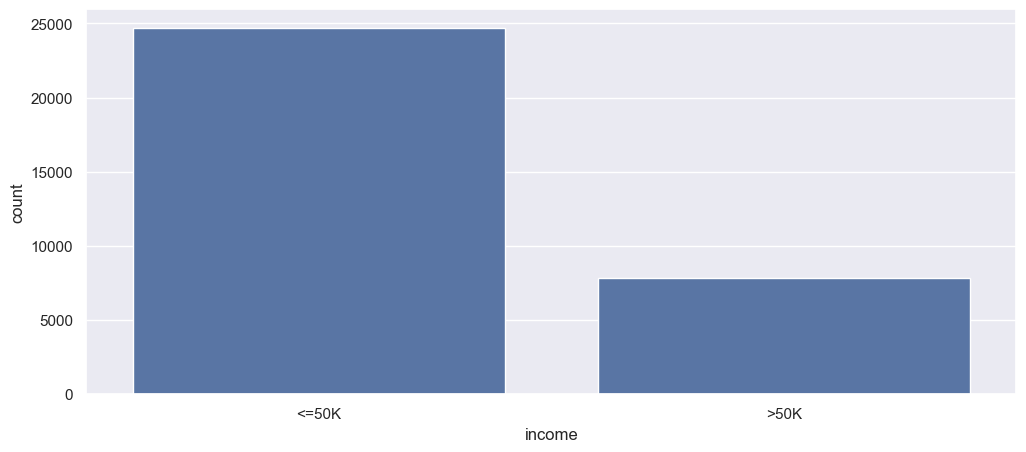

In [47]:
import seaborn as sns
sns.set(style="darkgrid")

# Número de valores para cada clase (categórica)
g = sns.countplot(df, x=target)

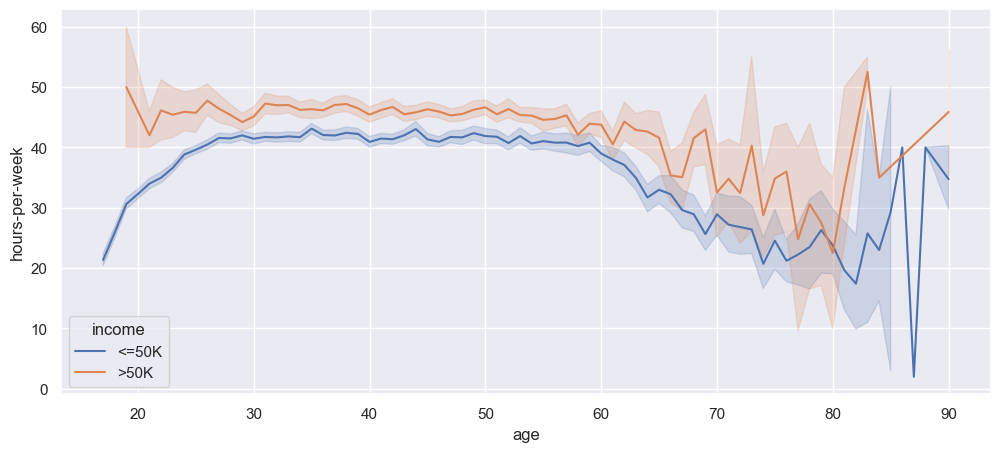

In [48]:
# Relación entre la edad (numérica) y las horas de trabajo por semana (numérica), diferenciando por clase
g = sns.lineplot(df, x='age', y='hours-per-week', hue='income')

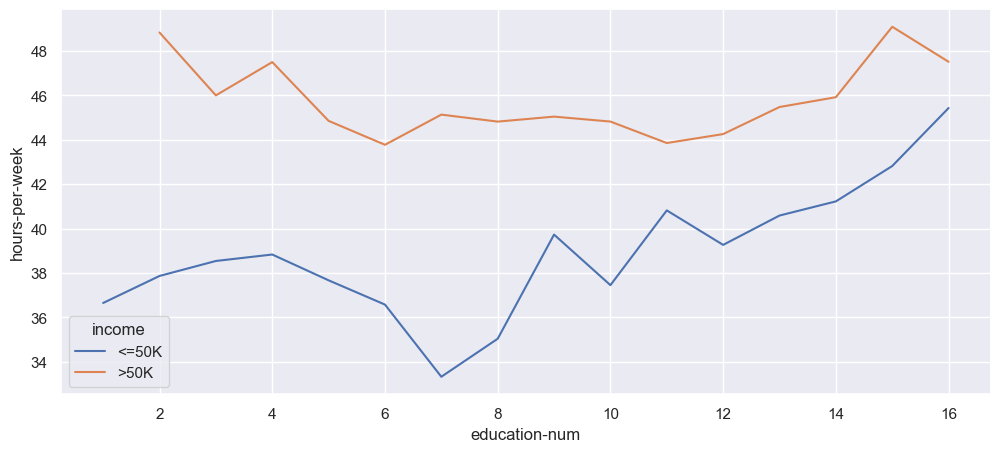

In [49]:
# Relación entre el nivel de educación (numérica) y las horas de trabajo por semana (numérica), diferenciando por clase y eliminando los intervalos de confianza
g = sns.lineplot(df, x='education-num', y='hours-per-week', hue='income', errorbar=None)

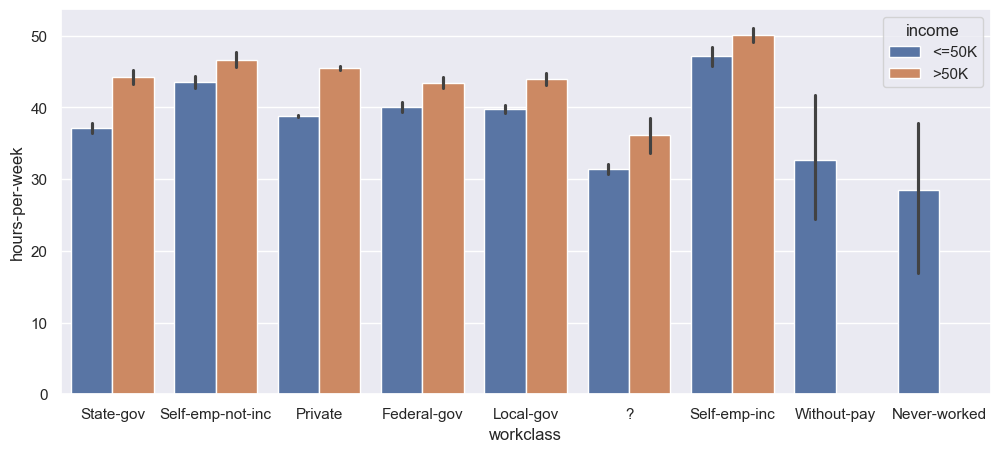

In [50]:
# Relación entre el tipo de trabajo (categórica) y las horas de trabajo por semana (numérica), diferenciando por clase
g = sns.barplot(df, x='workclass', y='hours-per-week', hue='income')

--- 

# 4. Implementación de un árbol de clasificación

En este apartado, vamos a implementar un árbol de clasificación C4.5. Se proporciona un modelo básico capaz de tratar variables categóricas, realizando las divisiones por error simple, y sin poda. Hay que ampliar el modelo para que cuente con las siguientes características:
1. Utilizar el índice GINI para el cálculo del error.
2. Utilizar la entropía condicional para el cálculo del error.
3. Utilizar variables continuas en el entrenamiento y predicción.
4. Poda del árbol.

Para la estructura del código vamos a seguir la de los algoritmos de `scikit-learn`. Por tanto, nuestro modelo `C45Classifier` heredará de [`BaseEstimator`](https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html), la clase base para todos los estimadores de `scikit-learn`, y de [`ClassifierMixin`](https://scikit-learn.org/stable/modules/generated/sklearn.base.ClassifierMixin.html), la clase base de los clasificadores. Además, debemos implementar los siguientes métodos principales: 

- `__init__()`: Constructor del modelo, recibirá los hiperparámetros necesarios.
- `fit(X,y)`: Método de entrenamiento del modelo. Recibe $X$ e $y$ y devuelve el modelo ya entrenado.
- `predict(X)`: Método de predicción del modelo. Recibe $X$ como un conjunto de instancias a predecir y devuelve $y_{pred}$, un vector de predicciones asociadas a $X$.

Por otro lado, está el siguiente método que, si bien es importante, al heredar de `ClassifierMixin` ya viene establecido por defecto a `accuracy_score`:
- `score(X,y)`: Método de evaluación del modelo. Recibe $X$ e $y$, predice $y_{pred}$ a partir de $X$, y devuelve el porcentaje de acierto de $y_{pred}$ respecto a $y$.

## 4.1 Clase `Node`
Antes de implementar la clase principal `C45Classifier`, vamos a crear una clase `Node` que codifique la información necesaria para cada uno de los nodos del árbol. Cuenta con las siguientes funciones:
- `__init__(self):` Constructor. En él inicializamos las variables necesarias, explicadas en los comentarios del código.
- `__str__(self):` Método que nos permite imprimir nuestros árboles.
- `predict(self,x):` Método que nos permitirá hacer predicciones recursivamente hasta llegar a un nodo hoja. Cuando el `Node` es hoja devuelve el valor de su clase, y si no, tendrá que llamar a la función `predict(x)` del hijo que corresponda. 

## **<font color="#B30033" size=6>TAREA: </font>** Método predict para variables continuas
El método `predict` actualmente se proporciona adaptado a la predicción de variables discretas. Deberéis ampliarlo para que funcione cuando la variable del nodo es continua.

In [ ]:
import random

class Node:
    def __init__(self):
        # Indica si el nodo es una hoja, o no
        self.is_leaf = False

        # Atributos relacionados con la variable que representa el nodo
        self.is_num = True      # Indica si la variable es numérica (True) o categórica (False)
        self.cat_dict = None    # Diccionario para variables categóricas con formato {valor: indice}
        
        # Atributos cuando el objeto es una raíz
        self.var = None         # Nombre de la variable de corte
        self.var_index = -1     # Índice de la variable de corte
        self.cut_value = 0      # Valor de la variable de corte, en caso de ser numérica
        self.children = []      # Lista de hijos

        # Atributos cuando el objeto es una hoja
        self.class_value = -1       # Valor de la clase si el nodo es hoja
        self.class_count = (0,0)    # Tupla con el formato (casos con valor class_value, casos totales en la hoja)

        # Profundidad del nodo
        self.depth = -1

    def __str__(self):
        output = ''
        if(self.is_leaf):
            output += 'Class value: ' + str(self.class_value) + '\tCounts: ' + str(self.class_count)
        else:
            output += 'Feature '+ str(self.var)
            for i in range(len(self.children)):
                output += '\n'+'\t'*(self.depth+1)+str(self.cut_value)+': '+str(self.children[i]) 
            
        return output
    
    # Esta función nos servirá para hacer predicciones recursivamente hasta llegar a un nodo hoja. Debe ser completada
    def predict(self,x):
        if self.is_leaf:
            return self.class_value
        else:
            if self.is_num:
                pass # TODO: Completar aquí
            else:
                pass # TODO: Completar aquí

## 4.2 Clase `C45Classifier`
Esta será la clase principal, que representará nuestro clasificador C4.5. Los argumentos que recibirá serán los siguientes:
* `vars`, `disc`, `cont`: 3 listas. Nombres de las variables con el mismo orden con el que aparecen en $X$, y de ellas, cuáles son discretas y cuales son continuas. No sería estrictamente necesario, pero simplificará bastante el desarrollo de la práctica.
* `max_depth`: Profundidad máxima del árbol. Si no se especifica, será 2.
* `criterion`: Criterio de partición. Puede tomar los valores `classification_error`, `entropy` y `gini`. Si no se especifica, será 'entropy'.
* `prune`: Booleano. Si es `True`, se podará el árbol. Si no se especifica, será `False`.


## **<font color="#B30033" size=6>TAREA: </font>** Implementación del índice GINI y la entropía condicional


## **<font color="#B30033" size=6>TAREA: </font>** Uso de variables continuas


## **<font color="#B30033" size=6>TAREA: </font>** Poda del árbol


In [ ]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from collections import Counter

class C45Classifier(BaseEstimator, ClassifierMixin):

    # Constructor de la clase, aquí se definen e inicializan las variables de la clase.
    def __init__(self, vars, disc, cont, max_depth=2, criterion='classification_error', prune=False):
        self.max_depth = max_depth
        self.criterion = criterion
        self.prune = prune

        self.vars = vars
        self.disc = disc
        self.cont = cont

        # Diccionario que nos permitirá convertir el nombre de la variable en su índice.
        self.features_dict = {feat: i for i, feat in enumerate(self.vars)}

        # Raíz del árbol
        self.tree = Node()   


    # Función para entrenar el modelo.
    def fit(self, X, y):
        # Llamada a la función recursiva que aprende el árbol.
        self._partial_fit(X, y, self.tree, 0, set([]))

        if self.prune:
            self._prune_tree()
        
        return self
    

    # Función para hacer predicciones.
    def predict(self, X):
        return np.array([self.tree.predict(x) for x in X])
    

    # Función recursiva que busca la variable y corte que maximiza la ganancia de información.
    # - Las variables continuas se tratan con un corte binario, lo que quiere decir que pueden ser usadas multiples veces. 
    # - Las variables discretas ramifican tantas veces como valores tengan, asi que solo pueden ser usadas una vez por camino, 
    #   debiendo almacenarlas en el conjunto `borradas`. 
    def _partial_fit(self, X, y, current_tree, current_depth, borradas):
        def _make_leaf():
            current_tree.is_leaf = True
            counts = Counter(y)
            max_value = counts.most_common(1) # most_common(1) devuelve una lista con el elemento más común y su frecuencia.
            current_tree.class_value = max_value[0][0]
            current_tree.class_count = (max_value[0][1], len(y))
            return
        
        # Antes de nada, si hemos alcanzado la profundidad máxima, el nodo se convierte en hoja.
        if current_depth >= self.max_depth:
            _make_leaf()
            return

        # Primero obtenemos el mejor punto de corte para el nodo actual dependiendo del criterio.
        best_var, cut_value, is_num = self._split(X, y, borradas, self.criterion)

        # Si no hay ninguna partición que mejore la actual, el nodo se convierte en hoja.
        if best_var is None:
            _make_leaf()
            return
    
        # Antes de llamar a la función recursiva, hay que actualizar los valores del árbol.
        borradas_copy = borradas.copy()
        if not is_num:    # Solo borramos las variables categóricas ya que estarán totalmente particionadas.
            borradas_copy.add(best_var)
            current_tree.is_num = False

        current_tree.is_leaf = False
        current_tree.depth = current_depth
        current_tree.var = best_var
        current_tree.var_index = self.features_dict[best_var]

        # Finalmente, se hace la llamada recursiva en función de si es numérica o categórica.
        if is_num:
            pass # TODO: Completar aquí.
        
        else:
            pass # TODO: Completar aquí.
        
        return


    # Cálculo del mejor punto de corte en función de: Error de clasificación.
    def _split(self, X, y, borradas, criterion='classification_error'):
        # Error actual (sin partición)
        error_best = self._compute_split_criterion(y, criterion)

        best_var = None
        is_num = True
        cut_value = None    # Para variables categóricas no hay valor de corte (devolvemos None).
        
        for var in self.vars:
            index = self.features_dict[var]
            
            if var in self.disc:
                pass # TODO: Completar aquí.
                
            elif var in self.cont:
                pass # TODO: Completar aquí.

            # Si conseguimos un error de 0 (óptimo), terminamos
            if error_best == 0:
                break

        return best_var, cut_value, is_num
    
    # TODO: Cálculo del mejor punto de corte en función de: Error de clasificación; Entropía; Índice Gini.
    def _compute_split_criterion(self, y, criterion='classification_error'):
        # TODO: Completar aquí si tenéis código común a los tres criterios.

        if criterion == 'classification_error':
            pass # TODO: Completar aquí.
        elif criterion == 'entropy':
            pass # TODO: Completar aquí.
        elif criterion == 'gini':
            pass # TODO: Completar aquí.
        else:
            raise ValueError('Criterio no válido.')

    
    # TODO: Completar esta función para realizar la poda del modelo.
    def _prune_tree(self):
        pass

    # Función para imprimir el modelo.
    def __str__(self):
        return str(self.tree)
    

--- 

# 5. Pruebas y estudio del algoritmo implementado

Finalmente, se deberán realizar pruebas con el clasificador para verificar su funcionamiento. A continuación, se incluyen algunos ejemplos de ejecución. Podéis incluir estos ejemplos en vuestra entrega, pero deberéis añadir más para demostrar que todas las partes de la práctica funcionan correctamente (variables continuas/discretas; error de clasificación/entropía/gini; con poda/sin poda, etc.). Además, se deberá razonar por qué los resultados son distintos de un caso a otro. 

Este apartado es más "libre", por lo que podéis hacer todas las pruebas y comparaciones que consideréis relevantes. Por ejemplo, podéis comparar vuestro algoritmo con los valores obtenidos por los árboles de `scikit-learn`, medir tiempos de ejecución... Además, si habéis incluido alguna característica opcional o distintiva de vuestro algoritmo, también debéis explicarla en este apartado.


### IMPORTANTE

**Se deberá mantener la eficiencia del clasificador. Esto significa que el tiempo de entrenamiento del árbol utilizando variables discretas o ambos tipos de variables debe ser similar. Obviamente, será mayor al incluir variables continuas en comparación con entrenar solo con las discretas (ya que solo se pueden particionar una vez), pero debe mantenerse dentro de un orden de magnitud similar.**

### Variables discretas, profundidad máxima 3, criterion='classification_error', sin poda

In [ ]:
arbol = C45Classifier(attributes, disc_atts, [], max_depth=3, criterion='classification_error', prune=False)
arbol.fit(X,y)

C45Classifier(cont=[],
              disc=Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object'),
              max_depth=3,
              vars=Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object'))

In [ ]:
print("Error en train: ", arbol.score(X,y))
print("Error en test:  ", arbol.score(X_test,y_test))

Error en train:  0.8317619237738398
Error en test:   0.8259934893434064


### Variables discretas, profundidad máxima 10, criterion='classification_error', sin poda

In [ ]:
# Al no estar implementado todavía el tratamiento de variables continuas, da igual que se especifiquen o no.
arbol = C45Classifier(attributes, disc_atts, [], max_depth=10, criterion='classification_error', prune=False)
arbol.fit(X,y)

C45Classifier(cont=[],
              disc=Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object'),
              max_depth=10,
              vars=Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object'))

In [ ]:
print("Error en train: ", arbol.score(X,y))
print("Error en test:  ", arbol.score(X_test,y_test))

Error en train:  0.8577746383710574
Error en test:   0.8208955223880597


### Variables discretas y continuas, profundidad máxima 2, criterion='classification_error', sin poda

In [ ]:
# Al no estar implementado todavía el tratamiento de variables continuas, da igual que se especifiquen o no.
arbol = C45Classifier(attributes, disc_atts, cont_atts, max_depth=2, criterion='classification_error', prune=False)
arbol.fit(X,y)

C45Classifier(cont=Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object'),
              disc=Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object'),
              vars=Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object'))

In [ ]:
print("Error en train: ", arbol.score(X,y))
print("Error en test:  ", arbol.score(X_test,y_test))

Error en train:  0.8160683025705598
Error en test:   0.8161660831644247
